In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
from tqdm.notebook import trange


In [3]:
n = 1000
p = n
d= 3

In [4]:
idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)])

idx

X= np.zeros([n,n])
for i in range(n):
    for j in range(0,i):
        X[i,j] = np.abs(j-i)+1

X[:,0]=1

idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)]).astype('int')

w0 = np.zeros([p])
w0[idx] = np.random.randn(d)+5
psi = X@w0


y = psi + np.random.randn(n) *1


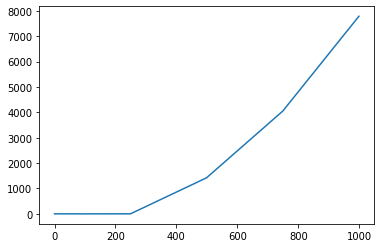

In [5]:
plt.plot(y)

In [6]:
X2 = X.T@X

In [7]:
Xy = X.T@y

In [8]:
Q,Lam,_ = np.linalg.svd(X2)

In [9]:
Lam = Lam[:(p-1)]
Q = Q[:,:(p-1)]

In [10]:
alpha = 10

theta =  np.linalg.solve(X2+np.eye(p),Xy) 

sigma2 = np.sum((y-X@theta)**2)/n

mu = np.random.uniform(0,1,1)
lam = np.random.uniform(0,1,p)*10

slab_indicator = (theta!=0)

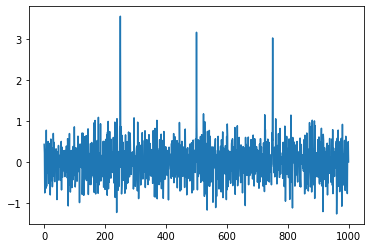

In [11]:
plt.plot(theta)

In [12]:
def Sample_a(theta,lam,sigma2,alpha ,slab_indicator):
    #inverse gaussain
    
    lam_tilde = 1./(1/lam+ 1/alpha)
    
    a = np.zeros(p)
    zero_idx = np.logical_not(slab_indicator)#np.abs(theta)==0
    non_zero_idx = slab_indicator #np.logical_not(zero_idx)

    if(np.sum(non_zero_idx)>0):
        ig_m = lam_tilde[non_zero_idx]* np.sqrt(sigma2)/ np.abs(theta[non_zero_idx])
        a[non_zero_idx] = 1/np.random.wald(ig_m, 1,np.sum(non_zero_idx) )

    a[zero_idx] = np.random.gamma(0.5,1/0.5, np.sum(zero_idx))
    return a

In [13]:
def inverse_gaussian_density(a, theta,lam,sigma , alpha):
    
    return  -np.log(2*np.pi)/2 - np.log(a)/2 - a* ( np.abs(theta)/a - lam*sigma)**2/2/(lam*sigma)**2

In [14]:
def a_density(a, theta,lam,sigma2, alpha):
    
    lam_tilde = 1./(1/lam+ 1/alpha)

    return  - np.log(a)/2 - theta**2/lam_tilde**2/2/sigma2/a - a/2

In [15]:
def SampleSlabIndicator(mu,lam,a,theta,sigma2,alpha,slab_indicator,eps=1E-3):


    p_slab = -mu/lam/np.sqrt(sigma2)
    p_spike = np.log(-np.expm1(p_slab))
    
    sigma = np.sqrt(sigma2)
    
    w1 = p_spike+ a_density(eps,theta,lam,sigma2,alpha) 
    w2 = p_slab + a_density(a,theta,lam,sigma2,alpha)

    slab = np.argmax(np.vstack([w1,w2]) + np.random.gumbel(0,1,[2,p]),0) ==1
    
    if (np.random.uniform(0,1,1)< slab.sum()/slab_indicator.sum()):
        s = slab
    else:
        s= slab_indicator

    return s

In [16]:
def SampleTheta(lam, a, sigma2, slab_indicator,alpha):

    lam_tilde = 1./(1/lam+ 1/alpha)
    
    a_star = np.zeros(p)

    a_star[slab_indicator]= a[slab_indicator]

    a_starlam = np.diag(a_star*lam_tilde**2)

    theta = np.zeros(p)

    if(np.sum(slab_indicator)>0):
    
        a_starlam_sub_inv = np.diag(1/ (a_star[slab_indicator]*lam_tilde[slab_indicator]**2))
        A = (X2[slab_indicator][:,slab_indicator] + a_starlam_sub_inv)
        theta0 = np.random.randn(slab_indicator.sum())
#         A_inv = np.linalg.inv(A)
#         theta[slab_indicator] = np.linalg.cholesky(A_inv) @theta0 * np.sqrt(sigma2) + A_inv@Xy[slab_indicator]
        LA = np.linalg.cholesky(A)
#         theta[slab_indicator] = np.linalg.inv(LA.T) @theta0 * np.sqrt(sigma2) + A_inv@Xy[slab_indicator]

        #  A = LA @LA.T   ==>.  A^{-1} = LA.T^{-1} LA^{-1}
        theta[slab_indicator] = np.linalg.solve(LA.T,theta0)     * np.sqrt(sigma2) + np.linalg.solve(LA.T, np.linalg.solve(LA, Xy[slab_indicator] ))
    
    
    return theta

In [17]:
# lam_tilde = 1./(1/lam+ 1/alpha)

# a_star = np.zeros(p)

# a_star[slab_indicator]= a[slab_indicator]

# a_starlam = np.diag(a_star*lam_tilde**2)

# theta = np.zeros(p)

# a_starlam_sub_inv = np.diag(1/ (a_star[slab_indicator]*lam_tilde[slab_indicator]**2))
# A = (X2[slab_indicator][:,slab_indicator] + a_starlam_sub_inv)
# theta0 = np.random.randn(slab_indicator.sum())
# #         A_inv = np.linalg.inv(A)
# #         theta[slab_indicator] = np.linalg.cholesky(A_inv) @theta0 * np.sqrt(sigma2) + A_inv@Xy[slab_indicator]
# LA = np.linalg.cholesky(A)

In [18]:
# A

In [19]:
def ExpCDF(x,lam):
    return 1- np.exp(-x/lam)

def ExpInvCDF(y,lam):
    return  -np.log1p(-y)*lam

In [20]:
def GenLowTruncExpo(m,a):

    lb = ExpCDF(a,m)
  
    if lb< (1- 1E-2):
        x = ExpInvCDF ( (1- lb)* np.random.uniform(0,1,1)+lb, m )
    else:
        x = a
        
    return x
    

In [21]:
def SampleT(mu, lam, slab_indicator, theta,sigma2):

#     c = np.sum(slab_indicator)
    m = lam *np.sqrt(sigma2)
        
    t = ExpInvCDF(ExpCDF(mu, m) * np.random.uniform(0,1,p), m) - mu
    t[slab_indicator] = np.abs(theta)[slab_indicator]
    return t

In [22]:
def SampleLam(t,slab_indicator,mu,sigma2):
    # lam prior: a,b
    a = 1

    b= 0.01


    beta = (t+mu)
    lam = 1/ np.random.gamma(a+1, 1/(beta/np.sqrt(sigma2)+ b ),p)
    
    
    return lam

In [23]:
    ig_m = alpha* np.sqrt(sigma2)/ np.sum(np.abs(theta))
    a_r = 1/np.random.wald(ig_m,1,1)

In [24]:
def SampleSigma2(theta, t,mu,lam, alpha, slab_indicator):
    
    beta = t+mu
    
    ig_m = lam* np.sqrt(sigma2)/ beta
    a_beta = 1/np.random.wald(ig_m,1,p)
    
    ig_m = alpha* np.sqrt(sigma2)/ np.sum(np.abs(theta))
    a_r = 1/np.random.wald(ig_m,1,1)
    

    #approximation
    b1 = np.sum((y-X@theta)**2)/2 + np.sum(beta**2/lam**2/a_beta)/2  + (np.sum(np.abs(theta))**2/alpha**2/a_r)/2
    a1 = n/2  + p/2 + 1.0/2.0 + 0.5 #0.5 is the jefferey's prior sigma^-0.5

    return 1/np.random.gamma(a1, 1/b1,1)

In [25]:
def SampleMu(sigma2,w, eps = 1E-3):

    def ComputeMu(w ,sigma2):

        a=1
        b= 0.01 * np.sqrt(sigma2)

    #         n_sim = int(1E6)
    #         mu = np.quantile(np.random.exponential(scale=1.0,size =n_sim)/ np.random.gamma(a,1./b, n_sim), 1-w)* np.sqrt(sigma2)

        mu = (w** (-1.0/a) -1)*b

        return mu



    def Compute_h_w(w):

        mu = ComputeMu(w, sigma2)

        p_slab = -mu/lam/np.sqrt(sigma2)
        p_spike = np.log(-np.expm1(p_slab))

        return (p_slab *slab_indicator + p_spike* (1.0-slab_indicator)).sum() +  (p**1.1-1)*np.log(1.0-w) #prior w\sim Beta(1,p^1.1)

#     while w_new <0:
#         w_new = w + np.random.uniform(- eps, eps,1)[0]
    
    forward_lb = np.max( [ w- eps,0])
    forward_ub = np.min( [ w+ eps,1])
    forward_density =  -np.log(forward_ub-forward_lb)
    
    w_new=  np.random.uniform(forward_lb, forward_ub,1)[0]
    
    backward_lb = np.max( [ w_new- eps,0])
    backward_ub = np.min( [ w_new+ eps,1])
    backward_density =  -np.log(backward_ub-backward_lb)

    if np.log(np.random.uniform(0,1,1)) < Compute_h_w(w_new)+backward_density - Compute_h_w(w)-forward_density:
        w = w_new
        accept = 1
    else:
        accept = 0
        
    mu = ComputeMu(w ,sigma2)
    return w, mu

In [26]:
trace_theta=[]

trace_slab=[]

In [27]:
sigma= 0.1
w = 1./p

In [28]:
for k in range(10000):

    a=  Sample_a(theta,lam,sigma2,alpha ,slab_indicator)
    
    slab_indicator= SampleSlabIndicator(mu,lam,a,theta,sigma2,alpha,slab_indicator,eps=1E-3)
    
    w,mu = SampleMu(sigma2,w, eps = 1E-3)    
    
    t = SampleT(mu, lam, slab_indicator, theta,sigma2)

    
    theta = SampleTheta(lam, a, sigma2, slab_indicator,alpha)

    lam = SampleLam(t,slab_indicator,mu,sigma2)
    sigma2 = SampleSigma2(theta, t,mu,lam, alpha, slab_indicator)
    
    if k>5000:
        trace_theta.append(theta)
        trace_slab.append(slab_indicator)

    if (k+1)%1000==0:
        print(k)
        print(slab_indicator.sum())



999
4
1999
3
2999
3
3999
4
4999
3
5999
3
6999
3
7999
3
8999
3
9999
3


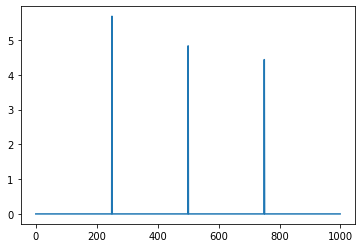

In [29]:
plt.plot(theta)

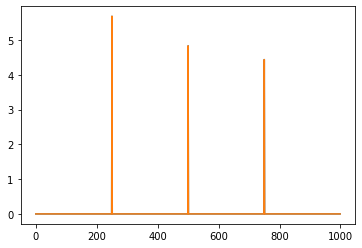

In [30]:
plt.plot(theta)
plt.plot(w0)

In [31]:
slab_indicator.sum()

3

In [32]:
theta_mat = np.vstack(trace_theta)
slab_mat = np.vstack(trace_slab)

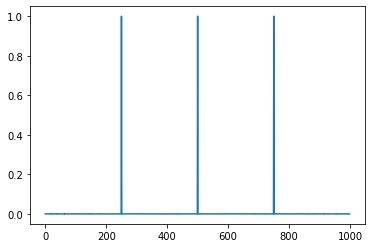

In [33]:
plt.plot(slab_mat.mean(0))

In [34]:
slab_indicator.sum()

3

In [35]:
from statsmodels.tsa.stattools import acf

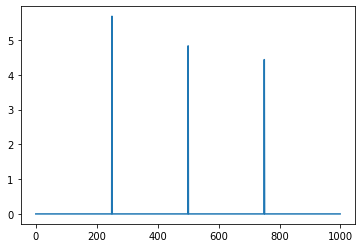

In [36]:
plt.plot(theta)

In [37]:
sigma2

array([0.97604089])

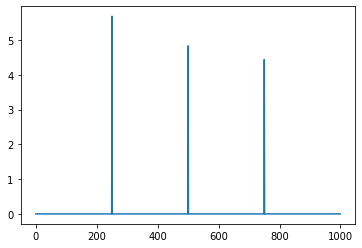

In [38]:
plt.plot(theta_mat.mean(0))

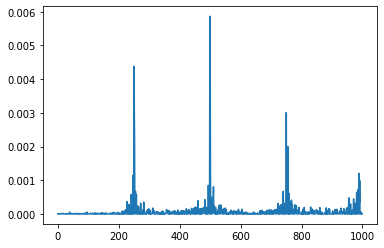

In [39]:
plt.plot(theta_mat.std(0))

In [40]:
# plt.plot((theta_mat!=0).sum(1))

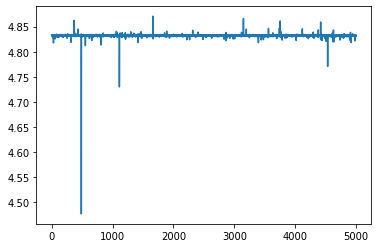

In [42]:
plt.plot((theta_mat[:,idx[1]]))

/home/shared/anaconda3/envs/leo/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


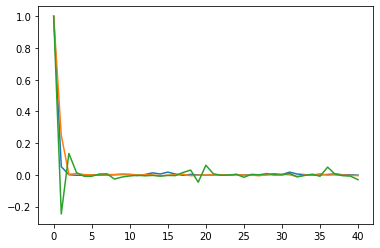

In [43]:
plt.plot(acf(theta_mat[:,idx[0]]))
plt.plot(acf(theta_mat[:,idx[1]]))
plt.plot(acf(theta_mat[:,idx[2]]))

In [44]:
sigma2

array([0.97604089])

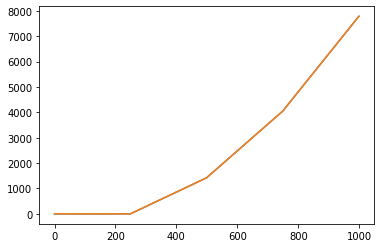

In [45]:
plt.plot(y)
plt.plot(X@theta)

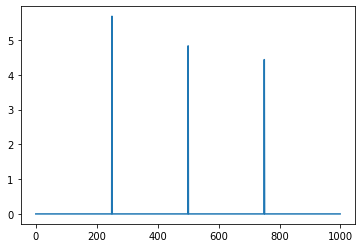

In [46]:
plt.plot(theta)

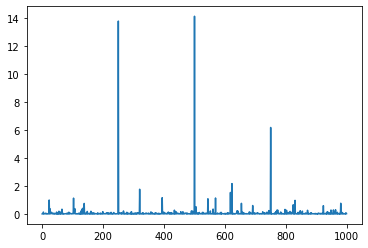

In [47]:
plt.plot(lam)

In [49]:
mu

array([3.30906534])

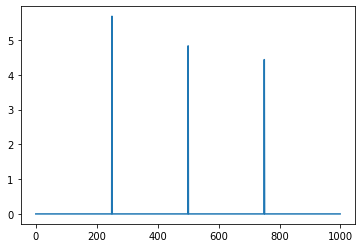

In [50]:
plt.plot(theta)

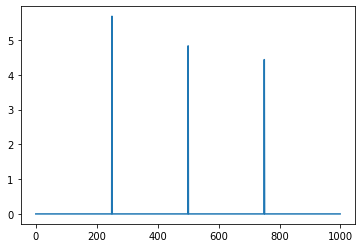

In [51]:
plt.plot(theta)